In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
import os
import itertools
import glob
import seaborn as sns
from scipy import stats

from data_loader import create_data_loader

In [3]:
label_files = ["../../../RatSI_v1.01/annotations/Observation{:02d}.csv".format(i) for i in range(1, 10)]
df = pd.concat([pd.read_csv(f, sep=";", index_col=0) for f in label_files], axis=0, ignore_index=True)

In [4]:
df["label"] = np.where(df.action == "Solitary", 0, 1)

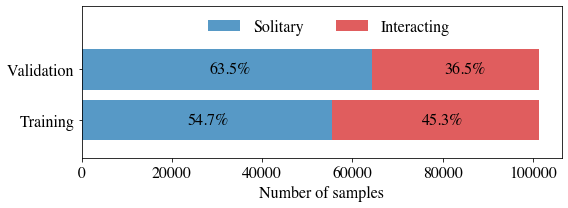

In [257]:
counts_train = pd.value_counts(df.label[(len(df) // 2):])
counts_valid = pd.value_counts(df.label[:(len(df) // 2)])

plt.figure(figsize=(8,3))
plt.barh(0, counts_train[0], height=0.8, color="tab:blue", alpha=0.75, label="Solitary")
plt.barh(0, counts_train[1], left=counts_train[0], height=0.8, color="tab:red", alpha=0.75, label="Interacting")
plt.barh(1, counts_valid[0], height=0.8, color="tab:blue", alpha=0.75)
plt.barh(1, counts_valid[1], left=counts_valid[0], height=0.8, color="tab:red", alpha=0.75)

plt.annotate("{:.01f}%".format(100 * counts_train[0] / (counts_train[1] + counts_train[0])), 
             (28000, 0), ha="center", va="center", fontsize=16, fontfamily="Times")
plt.annotate("{:.01f}%".format(100 * counts_train[1] / (counts_train[1] + counts_train[0])), 
             (80000, 0), ha="center", va="center", fontsize=16, fontfamily="Times")
plt.annotate("{:.01f}%".format(100 * counts_valid[0] / (counts_valid[1] + counts_valid[0])), 
             (33000, 1), ha="center", va="center", fontsize=16, fontfamily="Times")
plt.annotate("{:.01f}%".format(100 * counts_valid[1] / (counts_valid[1] + counts_valid[0])), 
             (85000, 1), ha="center", va="center", fontsize=16, fontfamily="Times")

plt.ylim(-0.75, 2.25)
plt.xlabel("Number of samples", fontsize=16, fontfamily="Times")

plt.xticks(fontsize=16, fontfamily="Times")
plt.yticks([0, 1], ["Training", "Validation"], fontsize=16, fontfamily="Times")

font = font_manager.FontProperties(family='Times', size=16)
plt.legend(prop=font, frameon=False, ncol=2, loc=(0.25, 0.77))

plt.tight_layout()
plt.savefig("eda-bar.png", dpi=500)

In [ ]:
tfrecord_file = "ratsi_data.tfrecord"
metadata_file = "ratsi_data.metadata.json"
dataset_train, dataset_valid = create_data_loader(
    tfrecord_file,
    metadata_file,
    valid_size=0.5,
    batch_size=1,
)

itr = dataset_train.as_numpy_iterator()

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

for i in range(10*25):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    img, label = next(itr)
    img = ax.imshow(img[0, ...] / 255., cmap="Greys_r", aspect="auto")
    ax.text(10, 15, "Interacting" if label else "Solitary", bbox=bbox_props, size=14)
    fig.savefig("sample_annot{:03d}.png".format(i), dpi=200)
    
os.system("convert -delay 4 -loop 0 sample_annot*.png sample_annot.gif")
files = glob.glob("./sample_annot*.png")
for f in files:
    try:
        os.remove(f)
    except:
        pass

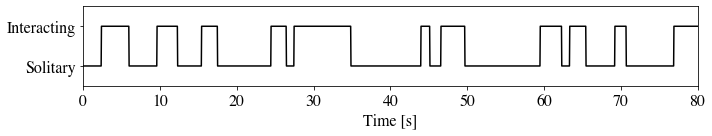

In [179]:
plt.figure(figsize=(10,2))
plt.plot(np.linspace(0, 2000 / 25, 2000), df.label.iloc[:2000], "k")
plt.xlabel("Time [s]", fontsize=16, fontfamily="Times")
plt.yticks([0, 1], ["Solitary", "Interacting"], fontsize=16, fontfamily="Times")
plt.xticks(fontsize=16, fontfamily="Times")
plt.ylim(-0.5, 1.5)
plt.xlim(0, 80)
plt.tight_layout()
plt.savefig("sample-label-hist.png", dpi=500)

In [32]:
lab = df.label.to_numpy()
grp = [(x, len(list(y))) for x, y in itertools.groupby(lab)]

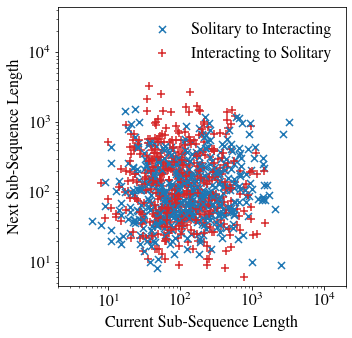

In [206]:
patt = [(grp[i][0], grp[i+1][0], grp[i][1], grp[i+1][1]) for i in range(len(grp)-1)]

plt.figure(figsize=(5, 4.8))
for i, p in enumerate(patt):
    plt.scatter(p[2], p[3], s=50, marker="+" if p[0] else "x",
                color="tab:red" if p[0] else "tab:blue",
                label=None if i > 1 else ("Solitary to Interacting" if p[1] else "Interacting to Solitary"))

plt.xscale("log")
plt.yscale("log")

plt.xlim(2e0, 2e4)
plt.ylim(4.5e0, 4.5e4)
plt.xlabel("Current Sub-Sequence Length", fontsize=16, fontfamily="Times")
plt.ylabel("Next Sub-Sequence Length", fontsize=16, fontfamily="Times")
plt.xticks(fontsize=16, fontfamily="Times")
plt.yticks(fontsize=16, fontfamily="Times")

font = font_manager.FontProperties(family='Times', size=16)
plt.legend(prop=font, frameon=False)

plt.tight_layout()
plt.savefig("eda-scatter.png", dpi=500)

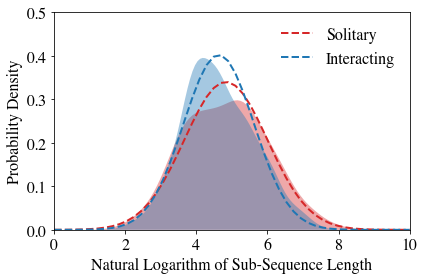

In [177]:
plt.figure()
for i in range(2):
    lens = [x[1] for x in grp if x[0] == i]
    log_lens = np.log(lens)
    sns.distplot(log_lens, color="tab:red" if i==0 else "tab:blue", kde=True,
                 hist=False, kde_kws={"lw": 0, "alpha": 0.4, "shade": True})
    xx = np.linspace(0, 10)
    plt.plot(xx, stats.norm.pdf(xx, loc=np.mean(log_lens), scale=np.std(log_lens)),
             color="tab:red" if i==0 else "tab:blue", ls="dashed",
             label="Solitary" if i==0 else "Interacting", lw=2)

plt.xlim(0, 10)
plt.ylim(0, 0.5)
plt.xlabel("Natural Logarithm of Sub-Sequence Length", fontsize=16, fontfamily="Times")
plt.ylabel("Probability Density", fontsize=16, fontfamily="Times")
plt.xticks(fontsize=16, fontfamily="Times")
plt.yticks(fontsize=16, fontfamily="Times")

font = font_manager.FontProperties(family='Times', size=16)
plt.legend(prop=font, frameon=False)

plt.tight_layout()
plt.savefig("eda-kde.png", dpi=500)